In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib


In [42]:
data_raw = pd.read_csv("marketing_campaign.csv", sep="\t")
data = data_raw.copy()

In [43]:
data = data.drop(columns=["ID", "Z_CostContact", "Z_Revenue"])

In [44]:
data['Income'] = data['Income'].fillna(data['Income'].median())

In [45]:
data["Age"] = 2025 - data["Year_Birth"]

In [46]:
data = data[(data["Age"] > 18) & (data["Age"] < 100)]

In [47]:
data["Family_Size"] = data["Kidhome"] + data["Teenhome"]

In [48]:
spend_features = ["MntWines","MntFruits","MntMeatProducts",
                  "MntFishProducts","MntSweetProducts","MntGoldProds"]
data["TotalSpend"] = data[spend_features].sum(axis=1)

In [49]:
purchase_features = ["NumDealsPurchases","NumWebPurchases",
                     "NumCatalogPurchases","NumStorePurchases"]
data["TotalPurchases"] = data[purchase_features].sum(axis=1)


In [50]:
q1, q3 = data["Income"].quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr
data = data[data["Income"] < upper]

In [73]:
max_income_count = (data['Income'] == data['Income'].max()).sum()
print("Count of rows with max Income:", max_income_count)

Count of rows with max Income: 1


In [51]:
data['Education'] = data['Education'].replace(['PhD', 'Master', "Graduation", "2n Cycle"], "Post Graduate")
data['Education'] = data['Education'].replace(["Basic"], "Under Graduate")

In [52]:
data['Marital_Status'] = data["Marital_Status"].replace(['Together', "Married"], "In-Relation")
data['Marital_Status'] = data["Marital_Status"].replace(['Single', "Divorced", 'Widow', 'Alone', 'Absurd', 'YOLO'], "Single")

In [53]:
X = data[["Income", "TotalSpend"]].copy()

In [54]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

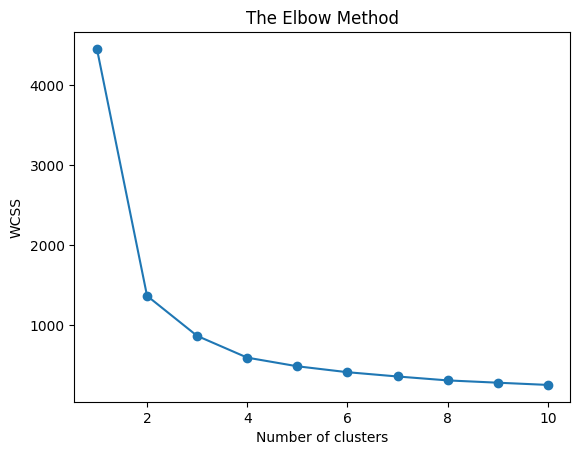

In [55]:
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss, marker="o")
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [76]:
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=42)
labels = kmeans.fit_predict(scaled_data)


In [77]:
print("Silhouette Score (KMeans):", silhouette_score(scaled_data, labels))

Silhouette Score (KMeans): 0.5895042592588309


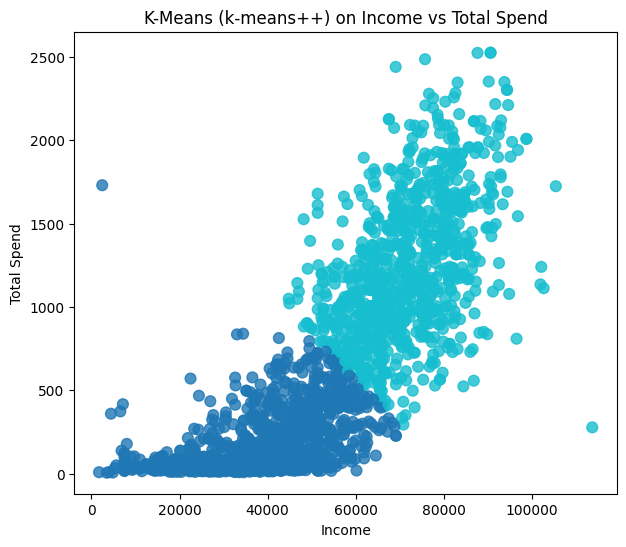

In [78]:
# Copy data and add cluster labels
data_clusters = data.copy()
data_clusters['Cluster'] = labels  # labels from KMeans prediction

# Quick 2D scatter plot for visual inspection
plt.figure(figsize=(7,6))
plt.scatter(
    data_clusters['Income'], 
    data_clusters['TotalSpend'],
    c=data_clusters['Cluster'], 
    s=60, 
    alpha=0.8, 
    cmap='tab10'
)
plt.xlabel("Income")
plt.ylabel("Total Spend")
plt.title("K-Means (k-means++) on Income vs Total Spend")
plt.show()


In [79]:
# Mean values of numeric features per cluster
cluster_means = data_clusters.groupby('Cluster')[["Age", "Income", "TotalSpend", "TotalPurchases"]].mean()

# Size of each cluster
cluster_sizes = data_clusters['Cluster'].value_counts().sort_index()

# Education distribution per cluster
edu_share = (
    data_clusters.groupby('Cluster')['Education']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .round(2)
)

# Marital Status distribution per cluster
marital_share = (
    data_clusters.groupby('Cluster')['Marital_Status']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .round(2)
)

# Combine everything into one compact profile
cluster_profile = pd.concat(
    [cluster_means, cluster_sizes.rename('Count'), edu_share, marital_share],
    axis=1
)

# Display cluster profile
cluster_profile


,Age,Income,TotalSpend,TotalPurchases,Count,Post Graduate,Under Graduate,In-Relation,Single
Cluster,,,,,,,,,
0,54.760820,37784.500000,176.477601,10.201974,1317,0.96,0.04,0.65,0.35
1,58.061404,71598.342654,1225.142544,21.608553,912,1.00,0.00,0.63,0.37


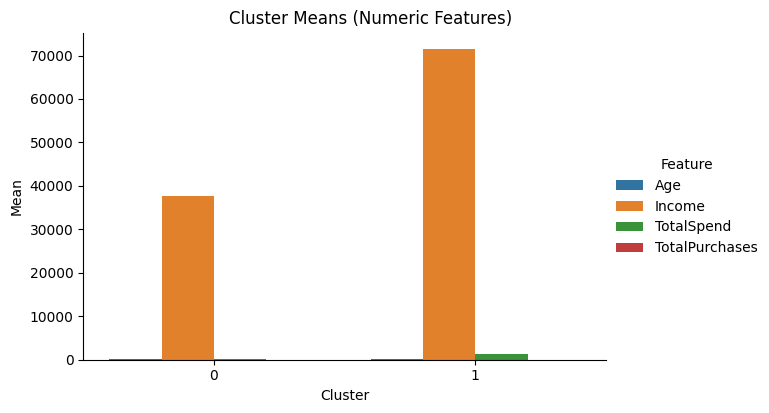

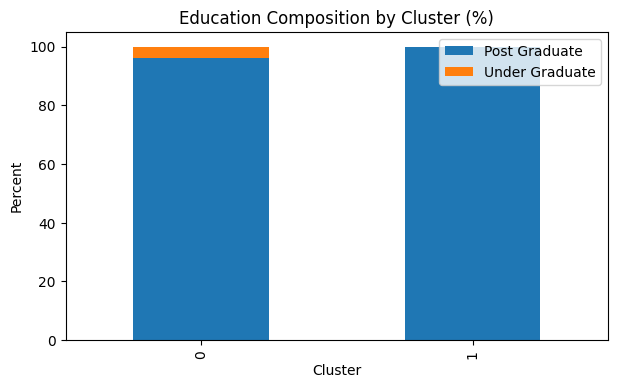

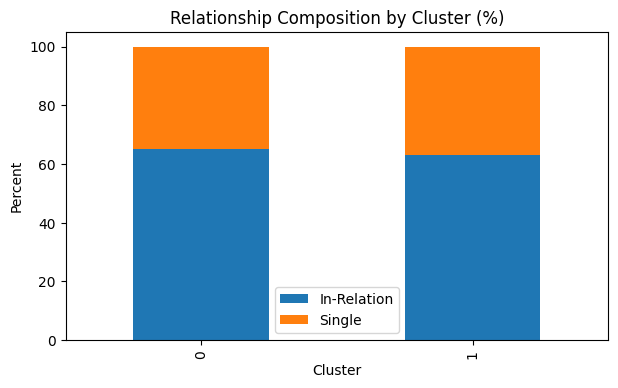

In [80]:
# === Bar plot: mean values per cluster (numeric features) ===
numeric_features = ["Age", "Income", "TotalSpend", "TotalPurchases"]
cluster_means = data_clusters.groupby('Cluster')[numeric_features].mean()

# Convert to long format for seaborn
means_long = cluster_means.reset_index().melt(
    id_vars='Cluster', var_name='Feature', value_name='Mean'
)

# Plot
g = sns.catplot(
    data=means_long, x='Cluster', y='Mean', hue='Feature',
    kind='bar', height=4, aspect=1.6
)
g.fig.suptitle("Cluster Means (Numeric Features)", y=1.02)
plt.show()

# === Stacked bar: categorical proportions (Education) ===
edu_share = cluster_profile[["Post Graduate","Under Graduate"]]
(edu_share * 100).plot(
    kind='bar', stacked=True, figsize=(7,4)
)
plt.ylabel("Percent")
plt.title("Education Composition by Cluster (%)")
plt.legend(loc='best')
plt.show()

# === Stacked bar: categorical proportions (Relationship) ===
rel_share = cluster_profile[["In-Relation","Single"]]
(rel_share * 100).plot(
    kind='bar', stacked=True, figsize=(7,4)
)
plt.ylabel("Percent")
plt.title("Relationship Composition by Cluster (%)")
plt.legend(loc='best')
plt.show()



In [81]:
# --- Define segment labels for 4 clusters ---
cluster_labels = {
    0: "High Income, High Spend → Premium Spenders",
    1: "Low Income, Low Spend → Thrifty Customers",
    2: "Mid Income, High Spend → Value Seekers",
    3: "Low Income, Mid Spend → Budget Explorers"
}

# --- Add Segment column to cluster profile ---
cluster_profile = cluster_profile.copy()
cluster_profile["Segment"] = cluster_profile.index.map(cluster_labels)

# --- Display final cluster profile ---
print(cluster_profile)


               Age        Income   TotalSpend  TotalPurchases  Count  \
Cluster                                                                
0        54.760820  37784.500000   176.477601       10.201974   1317   
1        58.061404  71598.342654  1225.142544       21.608553    912   

         Post Graduate  Under Graduate  In-Relation  Single  \
Cluster                                                       
0                 0.96            0.04         0.65    0.35   
1                 1.00            0.00         0.63    0.37   

                                            Segment  
Cluster                                              
0        High Income, High Spend → Premium Spenders  
1         Low Income, Low Spend → Thrifty Customers  


In [82]:
joblib.dump(scaler, "marketing_scaler.pkl")
joblib.dump(kmeans, 'marketing_kmeans_model.pkl')
joblib.dump(cluster_labels, 'marketing_cluster_lables.pkl')

print("model saved successfully")

model saved successfully
